In [3]:
import os
import pprint
import random
import gc
import signal
from collections import defaultdict
import time
from pathlib import Path
from typing import Annotated
import torch
import numpy as np
import tyro
import wandb
from dataclasses import dataclass
import yaml
from tqdm import tqdm
from mani_skill.utils import visualization
from mani_skill.utils.visualization.misc import images_to_video

from simpler_env.env.simpler_wrapper import SimlerWrapper
from simpler_env.utils.replay_buffer import SeparatedReplayBuffer

signal.signal(signal.SIGINT, signal.SIG_DFL)  # allow ctrl+c
os.environ["TOKENIZERS_PARALLELISM"] = "false"


@dataclass
class Args:
    env_id: Annotated[str, tyro.conf.arg(aliases=["-e"])] = "PutCarrotOnPlateInScene-v1"
    """The environment ID of the task you want to simulate. Can be one of
    PutCarrotOnPlateInScene-v1, PutSpoonOnTableClothInScene-v1, StackGreenCubeOnYellowCubeBakedTexInScene-v1, PutEggplantInBasketScene-v1"""

    """Number of environments to run. With more than 1 environment the environment will use the GPU backend 
    which runs faster enabling faster large-scale evaluations. Note that the overall behavior of the simulation
    will be slightly different between CPU and GPU backends."""

    seed: Annotated[int, tyro.conf.arg(aliases=["-s"])] = 0
    """Seed the model and environment. Default seed is 0"""

    name: str = "PPO-test"

    # env
    num_envs: int = 1 #64
    episode_len: int = 80
    use_same_init: bool = False

    steps_max: int = 2000000
    steps_vh: int = 0  # episodes
    interval_eval: int = 10
    interval_save: int = 40

    # buffer
    buffer_inferbatch: int = 32
    buffer_minibatch: int = 8
    buffer_gamma: float = 0.99
    buffer_lambda: float = 0.95

    # vla
    vla_path: str = "openvla/openvla-7b"
    vla_unnorm_key: str = "bridge_orig"
    vla_load_path: str = ""
    vla_lora_rank: int = 32

    vla_lr: float = 1e-4
    vla_vhlr: float = 3e-3
    vla_optim_beta1: float = 0.9
    vla_optim_beta2: float = 0.999
    vla_temperature: float = 1.0
    vla_temperature_eval: float = 0.6

    # ppo & grpo
    alg_name: str = "ppo"  # ppo, grpo
    alg_grpo_fix: bool = True
    alg_gradient_accum: int = 20
    alg_ppo_epoch: int = 1
    alg_entropy_coef: float = 0.0

    # other
    wandb: bool = True
    only_render: bool = False
    render_info: bool = False




/home/jovyan/.mlspace/envs/openvla_rl4vla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/.mlspace/envs/openvla_rl4vla/lib/python3.10/site-packages/sapien/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/jovyan/.mlspace/envs/openvla_rl4vla/lib/python3.10/site-packages/sapien/_vulkan_tricks.py:37: UserWarning: Failed to find Vulkan ICD file. This is probably due to an incorrect or partial installation of the NVIDIA driver. SAPIEN will attempt to provide an ICD file anyway but it may not work.
  warn(


mani_skill 3 imported


In [4]:
# import os 

# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"



In [5]:
args = Args()

# alg_name
assert args.alg_name in ["ppo", "grpo"]


device_id = 3


args.vla_path="gen-robot/openvla-7b-rlvla-rl"
args.vla_unnorm_key="bridge_orig"
args.vla_load_path=""


# # set wandb
# wandb.init(
#     config=args.__dict__,
#     project="RLVLA",
#     name=args.name,
#     mode="online" if args.wandb else "offline",
# )
save_dir = Path('./exps')
glob_dir = Path('./exps') / "glob"
glob_dir.mkdir(parents=True, exist_ok=True)

yaml.dump(args.__dict__, open(glob_dir / "config.yaml", "w"))

# policy
from simpler_env.policies.openvla.openvla_train import OpenVLAPolicy, OpenVLAPPO

# device_id_other = 1 if torch.cuda.device_count() > 1 else 0
device = torch.device("cuda:" + str(device_id))
policy = OpenVLAPolicy(args, device_id)

alg = OpenVLAPPO(args, policy)

# env
unnorm_state = policy.vla.get_action_stats(args.vla_unnorm_key)


2025-07-10 00:37:34.906547: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 00:37:34.955728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-10 00:37:34.955779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-10 00:37:34.957248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-10 00:37:34.966247: I tensorflow/core/platform/cpu_feature_guar

07/10 [00:38:02] WARNING  | >> Expected `transformers==4.40.1` and `tokenizers==0.19.1`   ]8;id=396387;file:///home/jovyan/nkachaev/RL4VLA_orig/openvla/prismatic/extern/hf/modeling_prismatic.py\modeling_prismatic.py]8;;\:]8;id=423034;file:///home/jovyan/nkachaev/RL4VLA_orig/openvla/prismatic/extern/hf/modeling_prismatic.py#229\229]8;;\
                          but got `transformers==4.49.0.dev0` and `tokenizers==0.21.2`;                            
                          there might be inference-time regressions due to dependency                              
                          changes. If in doubt, pleaseuse the above versions.                                      

Using value head mode: a0


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


trainable params: 112,991,744 || all params: 7,654,228,928 || trainable%: 1.4762


In [ ]:
obj_set = 'test'
args.env_id = "PutOnPlateInScene25MultiPlate-v1"
args.num_envs = 1
args.seed = 1
# args.episode_len

# set seed
np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)


env = SimlerWrapper(args, unnorm_state)


xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


In [ ]:
obs_img, instruction, info = env.reset(obj_set)

In [ ]:
instruction

['put plant on carpet']

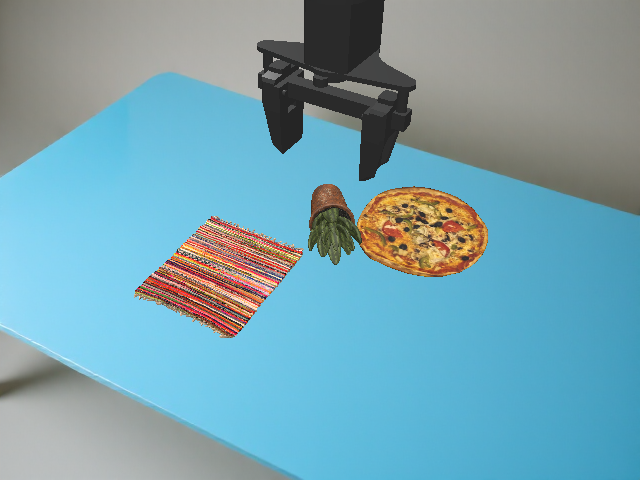

In [ ]:
from PIL import Image
Image.fromarray(obs_img[0].cpu().numpy())

In [ ]:

# buffer
buffer = SeparatedReplayBuffer(
    args,
    obs_dim=(480, 640, 3),
    act_dim=7,
)
minibatch_count = buffer.get_minibatch_count()
print(f"Buffer minibatch count: {minibatch_count}")

In [30]:

def _get_action(args, obs, deterministic=False):
    with torch.no_grad():
        total_batch = obs["image"].shape[0]

        values = []
        actions = []
        logprobs = []

        for i in range(0, total_batch, args.buffer_inferbatch):
            obs_batch = {k: v[i:i + args.buffer_inferbatch] for k, v in obs.items()}
            value, action, logprob = policy.get_action(obs_batch, deterministic)
            values.append(value)
            actions.append(action)
            logprobs.append(logprob)

        values = torch.cat(values, dim=0).to(device=device)
        actions = torch.cat(actions, dim=0).to(device=device)
        logprobs = torch.cat(logprobs, dim=0).to(device=device)

    return values, actions, logprobs


In [8]:
import os
from typing import Dict, List, Optional

import imageio
import numpy as np
import torch
import tqdm
from PIL import Image, ImageDraw, ImageFont

from mani_skill.utils.structs.types import Array

from IPython.display import Video, display  # <- добавлено

def images_to_video_my(
    images: List[Array],
    output_dir: str,
    video_name: str,
    fps: int = 10,
    quality: Optional[float] = 5,
    verbose: bool = True,
    show_in_notebook: bool = True,  # <- добавлен флаг
    **kwargs,
):
    r"""Calls imageio to run FFMPEG on a list of images. For more info on
    parameters, see https://imageio.readthedocs.io/en/stable/format_ffmpeg.html
    """
    assert 0 <= quality <= 10
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_name = video_name.replace(" ", "_").replace("\n", "_") + ".mp4"
    output_path = os.path.join(output_dir, video_name)

    writer = imageio.get_writer(output_path, fps=fps, quality=quality, **kwargs)

    if verbose:
        print(f"Creating video: {output_path}")
        images_iter = tqdm.tqdm(images)
    else:
        images_iter = images

    for im in images_iter:
        writer.append_data(im)
    writer.close()

    if verbose:
        print(f"Video saved to: {output_path}")

    if show_in_notebook:
        # Display video in notebook
        display(Video(output_path, embed=True))  # <-- показывает mp4 в ячейке

    return output_path  # возвращаем путь на случай, если нужно использовать дальше

In [9]:
# !pip list | grep transfor

In [10]:

# !pip uninstall transformers -y
# !pip install git+https://github.com/huggingface/transformers.git@1931a351408dbd1d0e2c4d6d7ee0eb5e8807d7bf

In [11]:
from transformers import AutoProcessor, AutoModelForVision2Seq

device_qwen = "cuda:3"

processor = AutoProcessor.from_pretrained("MINT-SJTU/RoboFAC-7B", trust_remote_code=True, torch_dtype=torch.float16)
model = AutoModelForVision2Seq.from_pretrained("MINT-SJTU/RoboFAC-7B", trust_remote_code=True, torch_dtype=torch.float16).to(device_qwen)

processor.patch_size = model.config.vision_config.patch_size
processor.num_additional_image_tokens = getattr(model.config.vision_config, "num_additional_image_tokens", 0)

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


In [ ]:
prompts = ['In the video, the robotic arm executes a task, was it successful?',
           'From the video of the robotic arm failing during the task, provide high-level corrective commands to guide it to recover and finish the task.',
           'This is a video of a robotic arm performing a task, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully.'
           ]

In [62]:
#@torch.no_grad()
policy.prep_rollout()

# init logger
env_infos = defaultdict(lambda: [])
datas = [{
    "image": [],  # obs_t: [0, T-1]
    "instruction": "",
    "action": [],  # a_t: [0, T-1]
    "info": [],  # info after executing a_t: [1, T]
} for idx in range(args.num_envs)]

obs_img, instruction, info = env.reset(obj_set)
print("instruction[:3]:", instruction[:3])

# data dump: instruction
for idx in range(args.num_envs):
    datas[idx]["instruction"] = instruction[idx]



instruction[:3]: ['put watering can on flat bowl']


In [63]:
args.first_steps_len = 10

In [64]:
for _ in range(args.first_steps_len):
    obs = dict(image=obs_img, task_description=instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 1.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.13, 'gripper_plate_dist': 0.1874, 'carrot_plate_dist': 0.1091, 'success': 0.0}
{'elapsed_steps': 2.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.1086, 'gripper_plate_dist': 0.1708, 'carrot_plate_dist': 0.1091, 'success': 0.0}
{'elapsed_steps': 3.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0852, 'gripper_plate_dist': 0.1548, 'carrot_plate_dist': 0.1091, 'success': 0.0}
{'elapsed_steps': 4.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0712, 'gripper_plate_dist': 0.1471, 'carrot_plate_dist': 0.1094, 'success': 0.0}
{'elapsed_steps': 5.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0644, 'gripper_plate_dist': 0.1381, 'carrot_plate_dist': 0.1094

In [65]:

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [38]:
len(datas[0]['image'])

14

In [39]:
task = instruction[0]
task

'put plant on carpet'

In [53]:
# prompt = f'In the video, the robotic arm executes a task {task}, was it successful?'

prompt = f'This is a video of a robotic arm performing a task {task}, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully. (Your answer should describe which direction (relative to the robot arm) and how much the robot arm should move to recover from the failure.)")'

messages = [
        {
        "role": "user",
        "content": [
            *[{"type": "image", "image": img} for img in datas[0]['image']],
            {"type": "text", "text": prompt}
        ],
        }
]
# print(f'prompt: {prompt}')
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    images=datas[0]['image'],
    padding=True,
    return_tensors="pt",
).to(device_qwen)
generated_tokens = model.generate(**inputs, max_new_tokens=2048)
output = processor.batch_decode(generated_tokens, skip_special_tokens=True)[0]
new_instruction = [output.split('assistant')[-1].strip('\n')]
print(f'{output}\n')


system
You are a helpful assistant.
user
This is a video of a robotic arm performing a task put plant on carpet, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully. (Your answer should describe which direction (relative to the robot arm) and how much the robot arm should move to recover from the failure.)")
assistant
Move the robot arm slightly backward to create space, then adjust the arm to the left to align with the center of the cup. After achieving alignment, lower the arm gently to grasp the cup securely before lifting it and moving towards the target position.



In [ ]:
# prompt = f'In the video, the robotic arm executes a task {task}, was it successful?'

prompt = f'This is a video of a robotic arm performing a task ({task}), please explain in detail the reason for the task failure. (Your answer should be a detailed textual description of about two to three sentences.)'

messages = [
        {
        "role": "user",
        "content": [
            *[{"type": "image", "image": img} for img in datas[0]['image']],
            {"type": "text", "text": prompt}
        ],
        }
]
# print(f'prompt: {prompt}')
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    images=datas[0]['image'],
    padding=True,
    return_tensors="pt",
).to(device_qwen)
generated_tokens = model.generate(**inputs, max_new_tokens=2048)
output = processor.batch_decode(generated_tokens, skip_special_tokens=True)[0]
print(f'{output}\n')


system
You are a helpful assistant.
user
This is a video of a robotic arm performing a task (put plant on carpet), please explain in detail the reason for the task failure. (Your answer should be a detailed textual description of about two to three sentences.)
assistant
The task failed because the robot arm was unable to grasp the cup due to an incorrect orientation of the gripper. Specifically, the end-effector did not align properly with the cup's position and shape, leading to a failure in securely grasping it. This misalignment indicates that the robot's approach was off, preventing it from completing the subsequent steps of lifting and moving the cup to the target position.



In [ ]:
new_instruction = [output.split('assistant')[-1].strip('\n')]


In [66]:
for _ in range(args.first_steps_len):
    obs = dict(image=obs_img, task_description=new_instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 11.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0369, 'gripper_plate_dist': 0.1592, 'carrot_plate_dist': 0.1346, 'success': 0.0}
{'elapsed_steps': 12.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0369, 'gripper_plate_dist': 0.1656, 'carrot_plate_dist': 0.1361, 'success': 0.0}
{'elapsed_steps': 13.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0369, 'gripper_plate_dist': 0.1535, 'carrot_plate_dist': 0.1209, 'success': 0.0}
{'elapsed_steps': 14.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.037, 'gripper_plate_dist': 0.1565, 'carrot_plate_dist': 0.1249, 'success': 0.0}
{'elapsed_steps': 15.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.037, 'gripper_plate_dist': 0.1494, 'carrot_plate_dist': 0

In [67]:

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [68]:
for _ in range(args.first_steps_len):
    obs = dict(image=obs_img, task_description=new_instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 21.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 1.0, 'gripper_carrot_dist': 0.0545, 'gripper_plate_dist': 0.0838, 'carrot_plate_dist': 0.0324, 'success': 1.0}
{'elapsed_steps': 22.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 1.0, 'gripper_carrot_dist': 0.0473, 'gripper_plate_dist': 0.0779, 'carrot_plate_dist': 0.033, 'success': 1.0}
{'elapsed_steps': 23.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 1.0, 'gripper_carrot_dist': 0.0373, 'gripper_plate_dist': 0.0671, 'carrot_plate_dist': 0.0326, 'success': 1.0}
{'elapsed_steps': 24.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 1.0, 'gripper_carrot_dist': 0.0372, 'gripper_plate_dist': 0.0669, 'carrot_plate_dist': 0.0326, 'success': 1.0}
{'elapsed_steps': 25.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 1.0, 'gripper_carrot_dist': 0.0431, 'gripper_plate_dist': 0.0751, 'carrot_plate_dist': 

In [69]:

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [59]:
for _ in range(3):
    obs = dict(image=obs_img, task_description=new_instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 33.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0367, 'gripper_plate_dist': 0.1964, 'carrot_plate_dist': 0.1736, 'success': 0.0}
{'elapsed_steps': 34.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0367, 'gripper_plate_dist': 0.2083, 'carrot_plate_dist': 0.1851, 'success': 0.0}
{'elapsed_steps': 35.0, 'is_src_obj_grasped': 1.0, 'consecutive_grasp': 1.0, 'src_on_target': 0.0, 'gripper_carrot_dist': 0.0367, 'gripper_plate_dist': 0.2059, 'carrot_plate_dist': 0.1836, 'success': 0.0}


In [60]:

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [43]:
# prompt = f'In the video, the robotic arm executes a task {task}, was it successful?'

prompt = f'This is a video of a robotic arm performing a task {task}, an error occurred during execution. Please provide low-level corrective commands to help the robot recover and complete the task successfully. (Your answer should describe which direction (relative to the robot arm) and how much the robot arm should move to recover from the failure.)")'

messages = [
        {
        "role": "user",
        "content": [
            *[{"type": "image", "image": img} for img in datas[0]['image']],
            {"type": "text", "text": prompt}
        ],
        }
]
# print(f'prompt: {prompt}')
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(
    text=[text],
    images=datas[0]['image'],
    padding=True,
    return_tensors="pt",
).to("cuda:0")
output = processor.batch_decode(model.generate(**inputs, max_new_tokens=2048), skip_special_tokens=True)[0]
new_instruction = [output.split('assistant')[-1].strip('\n')]
print(f'{output}\n')


OutOfMemoryError: CUDA out of memory. Tried to allocate 204.78 GiB. GPU 0 has a total capacity of 79.21 GiB of which 18.13 GiB is free. Including non-PyTorch memory, this process has 61.05 GiB memory in use. Of the allocated memory 51.55 GiB is allocated by PyTorch, and 7.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [15]:
args.second_steps_len = 10
# args.episode_len

In [16]:
for _ in range(args.first_steps_len):
    obs = dict(image=obs_img, task_description=instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 11.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.0, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 12.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.0156, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 13.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.0156, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 14.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.0312, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 15.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.0625, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 16.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.1094, 'consecutive_grasp': 0.0, 'src_on_target': 0.0, 'success': 

In [17]:
# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [18]:
for _ in range(args.episode_len):
    obs = dict(image=obs_img, task_description=instruction)
    value, action, logprob = _get_action(args, obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

{'elapsed_steps': 21.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.2344, 'consecutive_grasp': 0.0625, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 22.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.2812, 'consecutive_grasp': 0.0625, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 23.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.2969, 'consecutive_grasp': 0.1094, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 24.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.3125, 'consecutive_grasp': 0.1406, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 25.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.3281, 'consecutive_grasp': 0.1562, 'src_on_target': 0.0, 'success': 0.0}
{'elapsed_steps': 26.0, 'moved_correct_obj': 0.0, 'moved_wrong_obj': 0.0, 'is_src_obj_grasped': 0.3281, 'consecutive_grasp': 0.2031, 'src_on_targ

In [19]:
# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = './'#Path(glob_dir) / f"vis_{epoch}_{obj_set}"
# exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    # assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    if i == 0 or i == 1:
        images_to_video_my(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)




In [ ]:
# infos
env_stats = {k: np.mean(v) for k, v in env_infos.items()}
env_stats_ret = env_stats.copy()

print(pprint.pformat({k: round(v, 4) for k, v in env_stats.items()}))
print(f"")

# save stats
last_info = {
    idx: {k: env_infos[k][idx] for k in env_infos.keys()}
    for idx in range(args.num_envs)
}

save_stats = {}
save_stats["env_name"] = args.env_id
save_stats["ep_len"] = args.episode_len
save_stats["epoch"] = epoch
save_stats["stats"] = {k: v.item() for k, v in env_stats.items()}
save_stats["instruction"] = {idx: ins for idx, ins in enumerate(instruction)}
save_stats["last_info"] = last_info

yaml.dump(save_stats, open(exp_dir / "stats.yaml", "w"))

In [ ]:
for _ in range(args.episode_len):
    obs = dict(image=obs_img, task_description=instruction)
    value, action, logprob = _get_action(obs, deterministic=True)

    obs_img_new, reward, done, env_info = env.step(action)

    # info
    print({k: round(v.to(torch.float32).mean().tolist(), 4) for k, v in env_info.items() if k != "episode"})
    if "episode" in env_info.keys():
        for k, v in env_info["episode"].items():
            env_infos[f"{k}"] += v

    for i in range(args.num_envs):
        post_action = env._process_action(action)
        log_image = obs_img[i].cpu().numpy()
        log_action = post_action[i].cpu().numpy().tolist()
        log_info = {k: v[i].tolist() for k, v in env_info.items() if k != "episode"}
        datas[i]["image"].append(log_image)
        datas[i]["action"].append(log_action)
        datas[i]["info"].append(log_info)

    # update obs_img
    obs_img = obs_img_new

# data dump: last image
for i in range(args.num_envs):
    log_image = obs_img[i].cpu().numpy()
    datas[i]["image"].append(log_image)

# save video
exp_dir = Path(glob_dir) / f"vis_{epoch}_{obj_set}"
exp_dir.mkdir(parents=True, exist_ok=True)

for i in range(args.num_envs):
    images = datas[i]["image"]
    infos = datas[i]["info"]
    assert len(images) == len(infos) + 1

    if args.render_info:
        for j in range(len(infos)):
            images[j + 1] = visualization.put_info_on_image(
                images[j + 1], infos[j],
                extras=[f"Ins: {instruction[i]}"]
            )

    success = int(infos[-1]["success"])
    images_to_video(images, str(exp_dir), f"video_{i}-s_{success}",
                    fps=10, verbose=False)

# infos
env_stats = {k: np.mean(v) for k, v in env_infos.items()}
env_stats_ret = env_stats.copy()

print(pprint.pformat({k: round(v, 4) for k, v in env_stats.items()}))
print(f"")

# save stats
last_info = {
    idx: {k: env_infos[k][idx] for k in env_infos.keys()}
    for idx in range(args.num_envs)
}

save_stats = {}
save_stats["env_name"] = args.env_id
save_stats["ep_len"] = args.episode_len
save_stats["epoch"] = epoch
save_stats["stats"] = {k: v.item() for k, v in env_stats.items()}
save_stats["instruction"] = {idx: ins for idx, ins in enumerate(instruction)}
save_stats["last_info"] = last_info

yaml.dump(save_stats, open(exp_dir / "stats.yaml", "w"))

